In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importation des bibliothèques

In [3]:
import os
os.chdir("..")

# my modules
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
from Aspects.CoRefAspectIdentGrouping import CoRefAspectIdentGrouping

# pandas and numpy
import pandas as pd
import numpy as np

# spacy for NLP
import spacy

from time import time

#ignore pandas warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importation des données

In [4]:
# data = pd.read_csv("data/reviews_paris_hotels.csv")
data = pd.read_csv("data/trip_advisor_data_chunk_10000k.csv", encoding="utf-16")
data.rename(columns={"text": "review"}, inplace=True)
print(f"format de dataset: {data.shape}")
data.head(5)

format de dataset: (3000, 6)


,hotel_url,author,date,rating,title,review
0,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,Lagaiuzza,2016-01-01T00:00:00,5.0,"Baltic, what else?",We have spent in this hotel our summer holiday...
1,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,ashleyn763,2014-10-01T00:00:00,5.0,Excellent in every way!,I visited Hotel Baltic with my husband for som...
2,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,DavideMauro,2014-08-01T00:00:00,5.0,The house of your family's holiday,I've travelled quite a numbers of hotels but t...
3,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2017-03-01T00:00:00,5.0,Natural Luxury,"The property is surrounded by trees, which are..."
4,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,analuizade,2016-09-01T00:00:00,5.0,Very cozy!,I had a very pleasant stay at this hotel! All ...


In [16]:
data.loc[0, "review"]

'We have spent in this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

modification de commentaire avec index 0, pour vérifier la correction des fautes.

les mots modifiés sont:
- was -> wase
- perfect -> peerfecte
- during -> durin
- visit -> visite

In [41]:
data.loc[0, 'review'] = 'Le Bristol wase just peerfecte durin my trip to visite my son in Paris. With the pandemic, I was concerned if it would be the same sublime experience as it was in 2018 when I was last there. In some ways, it was even more so as they managed to meet and exceed cleanliness while at the same time not skipping a beat on providing outstanding service and truly three Michelin-star quality food. The atmosphere was so warm and helpful. I must again thank the concierge team led by Jean-Marie Burlet. They not only recommended excellent restaurants for us to try, local shops to visit, but they also secured hard to come by reservations for us, and tickets to exhibits. They also expertly packed up and mailed back to the States my purchases. Le Bristol is simply the best hotel. When I arrived I was greeted as an old friend. Jean-Marie remembered me and during my 8 night visit told me I’m family. It’s not often one feels that way about a hotel, but I must say the feeling is mutual. The Bristol is family to me too. Thank you.'
data.loc[0, 'review']

'Le Bristol wase just peerfecte durin my trip to visite my son in Paris. With the pandemic, I was concerned if it would be the same sublime experience as it was in 2018 when I was last there. In some ways, it was even more so as they managed to meet and exceed cleanliness while at the same time not skipping a beat on providing outstanding service and truly three Michelin-star quality food. The atmosphere was so warm and helpful. I must again thank the concierge team led by Jean-Marie Burlet. They not only recommended excellent restaurants for us to try, local shops to visit, but they also secured hard to come by reservations for us, and tickets to exhibits. They also expertly packed up and mailed back to the States my purchases. Le Bristol is simply the best hotel. When I arrived I was greeted as an old friend. Jean-Marie remembered me and during my 8 night visit told me I’m family. It’s not often one feels that way about a hotel, but I must say the feeling is mutual. The Bristol is fa

### Prétraitement de données
#### suppression des caractéristiques inutiles. (\n, \t, \r, liens, #..., @...)

In [5]:
preprocessor = ReviewPreprocessor(data['review'], spell_allowed_words= ["riad", "dar", "Riad", "Dar"])
data['cleaned_review'] = preprocessor.remove_tags()
data['cleaned_review']

0       We have spent in this hotel our summer holiday...
1       I visited Hotel Baltic with my husband for som...
2       I've travelled quite a numbers of hotels but t...
3       The property is surrounded by trees, which are...
4       I had a very pleasant stay at this hotel! All ...
                              ...                        
2995    We stayed in Portland for three nights and thi...
2996    It was my third time to stay at University pla...
2997    Stayed here for 4 nights in March and I chose ...
2998    I didn't expect much from this hotel from the ...
2999    The hotel rooms were clean and comfortable. Ni...
Name: cleaned_review, Length: 3000, dtype: object

#### correction des fautes d'orthographes

In [6]:
data['cleaned_review'] = preprocessor.spelling_correction()
data['cleaned_review'][0]

3000it [11:20,  4.41it/s]


'We have spent in this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discretion - minicab si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - minicab area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

les mots modifier dans le commentaires avec indice 0 sont bien corrigés.
- wase -> was
- peerfecte -> perfect
- durin -> during
- visite -> visit

#### suppression des phrases objectives

les phrases supprimé dans le commentaire 0 :
- With the pandemic, I was concerned if it would be the same sublime experience as it was in 2018 when I was last there.
- I must again thank the concierge team led by Jean-Marie bullet.
- They also expertly packed up and mailed back to the States my purchases.
- When I arrived I was greeted as an old friend.
- It’s not often one feels that way about a hotel, but I must say the feeling is mutual.

### Extraction des aspects

Dans cette phase, on extrait les noms les plus frequents comme des aspects.

In [220]:
nlp = spacy.load("en_core_web_sm")
now = time()
aspect_extractor = ExplicitAspectExtractor(data["cleaned_review"], nlp)
extracted_aspects = aspect_extractor.start(40)
print(extracted_aspects)
print(f"extracting aspects {time() - now}s")

[('room', 10568), ('hotel', 8232), ('staff', 5112), ('breakfast', 3796), ('place', 2956), ('food', 2924), ('restaurant', 2648), ('time', 2588), ('night', 2552), ('day', 2464), ('location', 2352), ('service', 2148), ('bed', 2120), ('area', 1912), ('pool', 1608), ('stay', 1476), ('beach', 1460), ('resort', 1344), ('water', 1328), ('bathroom', 1232), ('bar', 1216), ('view', 1196), ('price', 1180), ('lot', 1128), ('minute', 1092), ('shower', 1060), ('people', 1008), ('kid', 1000), ('guest', 948), ('dinner', 948), ('experience', 936), ('way', 932), ('family', 924), ('thing', 920), ('desk', 876), ('bit', 864), ('trip', 856), ('morning', 844), ('meal', 808), ('door', 792)]
extracting aspects 65.67227149009705s


on remarque que les apsects les plus frequents sont:
- room
- hotel
- staff
- location
- breakfast
- time
- restaurant
- service
- stay

...

In [205]:
aspects_ = list(dict(extracted_aspects).keys())

In [207]:
co_ref_aspect_ident_grouping = CoRefAspectIdentGrouping(data["cleaned_review"], dict(extracted_aspects), nlp)
aspect_sentiment = co_ref_aspect_ident_grouping.get_co_occurrence_matrix()
aspect_sentiment

,room,hotel,staff,breakfast,place,food,restaurant,time,night,day,...,distance,noise,value,wall,building,terrace,train,size,island,manager
qualified,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
helpful-,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
interesting,0.0,7.0,5.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,...,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0
smart-,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clean,440.0,135.0,104.0,55.0,30.0,32.0,17.0,9.0,13.0,17.0,...,2.0,4.0,6.0,3.0,5.0,5.0,2.0,15.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
troubling,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trim,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
satisfying,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extinguisher,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
from sklearn.decomposition import PCA

In [209]:
pca = PCA(n_components=2)
comps = pca.fit_transform(aspect_sentiment.to_numpy())

In [210]:
pca.explained_variance_ratio_

array([0.71510228, 0.10854828])

In [211]:
import seaborn as sns

<AxesSubplot:>

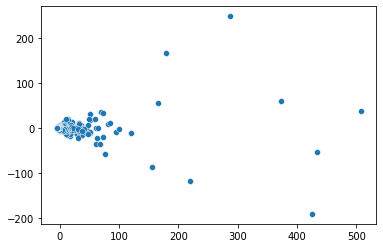

In [212]:
sns.scatterplot(x = comps[:,0], y = comps[:,1])

In [59]:
review_sentences = []
for id_, review in tqdm(data["cleaned_review"].items()):    
    doc = nlp(review)
    sentences = []
    for sentence in doc.sents:
        sentence_words = []
        for word in sentence:
            if (not word.is_digit) and (not word.is_punct) and word.pos_ == "NOUN":
                word = word.lemma_.lower().replace("-", " ")
                sentence_words.append(word)
        review_sentences.append(sentence_words)

3000it [01:07, 44.28it/s]


In [13]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [60]:
model_wv = Word2Vec(sentences=review_sentences, vector_size=300, window=5, min_count=5, workers=2, sg = 1)

In [225]:
aspect_pairs_list = [set([i]) for i in set(aspects_)]
for aspect in aspects_:
    similar_words = model_wv.wv.similar_by_word(aspect, topn=10)
    for similar_word in similar_words:
        similarity = similar_word[1]
        if similarity >= 0.985 and similar_word[0] in aspects_:
            pair = {aspect, similar_word[0]}
            if pair not in aspect_pairs_list:
                aspect_pairs_list.append(pair)

"""
		for aspect in self.__aspects:
			similar_words = self.model_wv.wv.similar_by_word(aspect, topn=15)
			for similar_word in similar_words:
				similarity = similar_word[1]
				if similarity >= threshold and similar_word[0] in self.__aspects:
					pair = {aspect, similar_word[0]}
					if pair not in aspect_pairs_list:
						aspect_pairs_list.append(pair)
"""

In [168]:
aspect_pairs_list = [set([i]) for i in set(aspects_)]
for aspect in aspects_:
    for aspect2 in aspects_:
        if aspect != aspect2:
            similarity = model_wv.wv.similarity(aspect, aspect2)
            pair = {aspect, aspect2}
            if similarity >= 0.993 and pair not in aspect_pairs_list:
                aspect_pairs_list.append(pair)

In [223]:
for i, aspect_pair in enumerate(aspect_pairs_list):
    aspect_pairs_list[i] = list(aspect_pair)

In [121]:
def get_groups(d, l, s=[]):
    if not (r:=[i for i in d if any(j in l for j in i) and i not in s]):
        yield list(set(l))
        if (new_r:=[i for i in d if i not in s]):
            yield from get_groups(d, new_r[0], s=s+[new_r[0]])
    else:
        yield from get_groups(d, l+[i for k in r for i in k], s=s+r)

In [224]:
aspects_groups = list(get_groups(aspect_pairs_list, aspect_pairs_list[0]))
dict_aspects_frequency = dict(extracted_aspects)
group_names = []
for group in aspects_groups:
    max_of_group = ("",0)
    for item in group:
        freq = dict_aspects_frequency[item]
        if freq > max_of_group[1]:
            max_of_group = (item, freq)
    group_names.append(max_of_group[0])

KeyError: 'air'

In [188]:
named_explicite_aspects = {}
for i, group_name in enumerate(group_names):
    named_explicite_aspects[group_name] = aspects_groups[i]
named_explicite_aspects

{'room': ['bathroom', 'bed', 'water', 'door', 'shower', 'room', 'floor'],
 'staff': ['coffee',
  'evening',
  'experience',
  'bar',
  'morning',
  'meal',
  'breakfast',
  'food',
  'price',
  'restaurant',
  'service',
  'drink',
  'dinner',
  'stay',
  'staff',
  'resort'],
 'place': ['trip', 'riad', 'parking', 'place', 'beach', 'way'],
 'time': ['people',
  'reception',
  'night',
  'time',
  'desk',
  'thing',
  'area',
  'pool',
  'guest',
  'family',
  'kid'],
 'minute': ['minute'],
 'hour': ['hour'],
 'hotel': ['street', 'hotel', 'location', 'city'],
 'view': ['view'],
 'bit': ['bit'],
 'lot': ['lot'],
 'day': ['day']}

In [ ]:
for i in named_explicite_aspects["time"]:
    for j in named_explicite_aspects["time"]:   
        similarity = model_wv.wv.similarity(i, j)
        if similarity > 0.993:
            print(i, j, similarity)

In [227]:
model_wv.wv.similarity("front", "year")

0.9930829

In [231]:
co_ref_aspect_ident_grouping.model_wv = None

In [233]:
co_ref_aspect_ident_grouping.get_co_reference_aspects_groups()

{'bed': ['shower', 'bathroom', 'bed', 'air'],
 'door': ['wall', 'door'],
 'restaurant': ['restaurant'],
 'beach': ['beach'],
 'towel': ['towel'],
 'breakfast': ['evening',
  'morning',
  'meal',
  'breakfast',
  'choice',
  'dinner',
  'buffet'],
 'night': ['couple', 'night', 'year', 'week', 'day'],
 'people': ['guest', 'people'],
 'hotel': ['riad', 'hotel', 'resort'],
 'pool': ['pool'],
 'way': ['way'],
 'desk': ['desk', 'reception', 'manager'],
 'time': ['time'],
 'street': ['building', 'street', 'road'],
 'size': ['size'],
 'drink': ['drink'],
 'place': ['place'],
 'view': ['terrace', 'view'],
 'food': ['service', 'food'],
 'price': ['money', 'value', 'price'],
 'thing': ['thing'],
 'kid': ['family', 'child', 'kid'],
 'quality': ['quality'],
 'parking': ['parking'],
 'stay': ['stay'],
 'minute': ['minute', 'distance', 'station', 'walk', 'train', 'airport'],
 'area': ['area'],
 'car': ['car'],
 'hour': ['hour'],
 'location': ['location'],
 'bit': ['bit'],
 'experience': ['experience'